In [2]:

##  Cell 1: Environment Setup & GPU Verification



import os
import warnings
warnings.filterwarnings('ignore')

# Check GPU availability
import torch
print(f"PyTorch Version: {torch.__version__}")
print(f"CUDA Available: {torch.cuda.is_available()}")
if torch.cuda.is_available():
    print(f"GPU Device: {torch.cuda.get_device_name(0)}")
    print(f"GPU Memory: {torch.cuda.get_device_properties(0).total_memory / 1e9:.2f} GB")
else:
    print("WARNING: No GPU detected. Training will be very slow.")

# Set device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"\nUsing device: {device}")


PyTorch Version: 2.6.0+cu124
CUDA Available: True
GPU Device: Tesla P100-PCIE-16GB
GPU Memory: 17.06 GB

Using device: cuda


In [3]:

# Install required packages



# Imports
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from PIL import Image
import zipfile
import json
from pathlib import Path
from tqdm.auto import tqdm
import random
import re

# PyTorch
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from torch.optim import AdamW
from torch.optim.lr_scheduler import ReduceLROnPlateau

# Transformers
from transformers import AutoTokenizer, AutoModel, DebertaV2Model, DebertaV2Tokenizer

# Image models
import timm
from torchvision import transforms

# Metrics
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score,
    confusion_matrix, classification_report, roc_auc_score
)

print("✅ All imports successful!")


2025-11-10 16:15:50.744386: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1762791350.940106      39 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1762791350.993064      39 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


✅ All imports successful!


In [4]:

# Set random seeds for reproducibility
def set_seed(seed=42):
    """Set random seeds for reproducibility across multiple libraries."""
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False
    os.environ['PYTHONHASHSEED'] = str(seed)
    print(f"🌱 Random seed set to {seed}")

set_seed(42)


🌱 Random seed set to 42


In [5]:
DATA_DIR = "/kaggle/input/multimodal-fusion-based-fake-news-detection/AAAI_dataset/"

# Check contents of dataset directory
print(f"🔍 Listing files and folders in {DATA_DIR}:")
for item in os.listdir(DATA_DIR):
    print(f"- {item}")

# List all CSV files in the data directory
csv_files = [f for f in os.listdir(DATA_DIR) if f.endswith('.csv')]
print(f"\n📄 CSV files found: {csv_files}")

# Check Images folder and list its contents
Images_folder = os.path.join(DATA_DIR, "Images")
if os.path.exists(Images_folder):
    print(f"\n🖼️ Images folder found: {Images_folder}")
    print("Subfolders inside Images:")
    for subfolder in os.listdir(Images_folder):
        print(f"- {subfolder}")
else:
    print("\n❌ Images folder not found!")

# Load and preview the first CSV file
if csv_files:
    sample_csv_path = os.path.join(DATA_DIR, csv_files[0])
    df = pd.read_csv(sample_csv_path)
    print(f"\nSample data from {csv_files[0]}:")
    print(df.head())
else:
    print("\n❌ No CSV files found to load.")

🔍 Listing files and folders in /kaggle/input/multimodal-fusion-based-fake-news-detection/AAAI_dataset/:
- gossip_test.csv
- politi_test.csv
- Images
- politi_train.csv
- gossip_train.csv

📄 CSV files found: ['gossip_test.csv', 'politi_test.csv', 'politi_train.csv', 'gossip_train.csv']

🖼️ Images folder found: /kaggle/input/multimodal-fusion-based-fake-news-detection/AAAI_dataset/Images
Subfolders inside Images:
- gossip_train
- gossip_test
- politi_test
- politi_train

Sample data from gossip_test.csv:
   Unnamed: 0                                            content  \
0           0  JR Smith's Daughter Released from NICU After B...   
1           1  Sofia Richie Has a Scott Disick Phone Case and...   
2           2  Everything We Know About Brad Pitt’s Plane Inc...   
3           3  Kate Middleton Secretly Donated Her 7 Inches o...   
4           4  General Gabbery: DWTS Or sign in with one of t...   

                                  image  label  
0  01r40J3oClyYJCLDrlzSYJ5c69lHOMu

In [6]:
def load_dataset_info():
    """Load all CSV files and show basic information."""
    datasets = {}
    csv_files = ['politi_train.csv', 'politi_test.csv', 'gossip_train.csv', 'gossip_test.csv']
    
    for csv_file in csv_files:
        csv_path = os.path.join(DATA_DIR, csv_file)
        if os.path.exists(csv_path):
            df = pd.read_csv(csv_path)
            datasets[csv_file.replace('.csv', '')] = df
            print(f"\n📊 {csv_file}:")
            print(f"   Shape: {df.shape}")
            print(f"   Columns: {df.columns.tolist()}")
            if 'label' in df.columns:
                print(f"   Label distribution: {df['label'].value_counts().to_dict()}")
            print(f"   Sample content length: {df['content'].str.len().describe()}")
        else:
            print(f"❌ {csv_file} not found!")
    
    return datasets

datasets = load_dataset_info()




📊 politi_train.csv:
   Shape: (381, 4)
   Columns: ['Unnamed: 0', 'content', 'image', 'label']
   Label distribution: {1: 246, 0: 135}
   Sample content length: count       381.000000
mean       8919.191601
std       17501.565473
min          42.000000
25%         677.000000
50%        2511.000000
75%        6826.000000
max      100155.000000
Name: content, dtype: float64

📊 politi_test.csv:
   Shape: (104, 4)
   Columns: ['Unnamed: 0', 'content', 'image', 'label']
   Label distribution: {1: 75, 0: 29}
   Sample content length: count       104.000000
mean       9494.240385
std       18349.907226
min          45.000000
25%         657.500000
50%        2966.500000
75%        7677.000000
max      100077.000000
Name: content, dtype: float64

📊 gossip_train.csv:
   Shape: (10010, 4)
   Columns: ['Unnamed: 0', 'content', 'image', 'label']
   Label distribution: {1: 7974, 0: 2036}
   Sample content length: count     10010.000000
mean       3427.515884
std        5872.623572
min          34.

In [7]:
# Verify Image Files
def verify_images(datasets):
    """Check if image files exist for all CSV entries (case-insensitive)."""
    image_stats = {}

    for dataset_name, df in datasets.items():
        if df is not None:
            # Normalize column names for safety
            df.columns = df.columns.str.strip().str.lower()

            if 'image' in df.columns:
                # Determine image folder based on dataset name
                img_folder = os.path.join(DATA_DIR, 'Images', dataset_name)

                if os.path.exists(img_folder):
                    available_images = set(os.listdir(img_folder))
                    required_images = set(df['image'].astype(str).tolist())

                    missing_images = required_images - available_images

                    image_stats[dataset_name] = {
                        'total_required': len(required_images),
                        'available': len(available_images),
                        'missing': len(missing_images),
                        'folder': img_folder
                    }

                    print(f"\n🖼️ {dataset_name} Images:")
                    print(f"   Folder: {img_folder}")
                    print(f"   Required: {len(required_images)}")
                    print(f"   Available: {len(available_images)}")
                    print(f"   Missing: {len(missing_images)}")

                    if missing_images:
                        print(f"   First few missing: {list(missing_images)[:5]}")
                else:
                    print(f"❌ Image folder not found: {img_folder}")

    return image_stats


# Run verification
image_stats = verify_images(datasets)



🖼️ politi_train Images:
   Folder: /kaggle/input/multimodal-fusion-based-fake-news-detection/AAAI_dataset/Images/politi_train
   Required: 381
   Available: 381
   Missing: 0

🖼️ politi_test Images:
   Folder: /kaggle/input/multimodal-fusion-based-fake-news-detection/AAAI_dataset/Images/politi_test
   Required: 104
   Available: 104
   Missing: 0

🖼️ gossip_train Images:
   Folder: /kaggle/input/multimodal-fusion-based-fake-news-detection/AAAI_dataset/Images/gossip_train
   Required: 9988
   Available: 9988
   Missing: 0

🖼️ gossip_test Images:
   Folder: /kaggle/input/multimodal-fusion-based-fake-news-detection/AAAI_dataset/Images/gossip_test
   Required: 2828
   Available: 2828
   Missing: 0


In [8]:
# Text Preprocessing
def clean_text(text):
    """Clean and preprocess text content."""
    if pd.isna(text):
        return ""

    text = str(text)
    # Remove URLs
    text = re.sub(r'http\S+|www\S+|https\S+', '', text, flags=re.MULTILINE)
    # Remove extra whitespace
    text = re.sub(r'\s+', ' ', text)
    # Remove special characters but keep punctuation
    text = re.sub(r'[^\w\s\.,!?;:]', '', text)
    return text.strip()

# Test text cleaning
sample_text = "Check out this link: https://example.com and www.fake-news.com   Multiple   spaces    here!!!"
print(f"Original: {sample_text}")
print(f"Cleaned: {clean_text(sample_text)}")


Original: Check out this link: https://example.com and www.fake-news.com   Multiple   spaces    here!!!
Cleaned: Check out this link: and Multiple spaces here!!!


In [9]:
# Image Preprocessing Setup
IMG_SIZE = 300  # EfficientNet-B3 default input size
MEAN = [0.485, 0.456, 0.406]  # ImageNet normalization
STD = [0.229, 0.224, 0.225]

# Training transforms (with augmentation)
train_transforms = transforms.Compose([
    transforms.Resize((IMG_SIZE, IMG_SIZE)),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.RandomRotation(degrees=10),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1),
    transforms.ToTensor(),
    transforms.Normalize(mean=MEAN, std=STD)
])

# Validation/Test transforms (no augmentation)
val_transforms = transforms.Compose([
    transforms.Resize((IMG_SIZE, IMG_SIZE)),
    transforms.ToTensor(),
    transforms.Normalize(mean=MEAN, std=STD)
])

print(f"🖼️  Image preprocessing setup:")
print(f"   Input size: {IMG_SIZE}x{IMG_SIZE}")
print(f"   Normalization: mean={MEAN}, std={STD}")



🖼️  Image preprocessing setup:
   Input size: 300x300
   Normalization: mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]


In [10]:
# PyTorch Dataset Class
class MultimodalFakeNewsDataset(Dataset):
    """
    Dataset class for multimodal fake news detection.
    Handles both text and image data loading with proper preprocessing.
    """

    def __init__(self, df, img_folder, tokenizer, transform=None, max_length=256):
        self.df = df.copy().reset_index(drop=True)
        self.img_folder = img_folder
        self.tokenizer = tokenizer
        self.transform = transform
        self.max_length = max_length

        # Normalize column names to lowercase
        self.df.columns = self.df.columns.str.strip().str.lower()

        # Clean text data
        self.df['content'] = self.df['content'].apply(clean_text)

        # Filter out missing images if necessary
        if img_folder and os.path.exists(img_folder):
            available_images = set(os.listdir(img_folder))
            initial_len = len(self.df)
            self.df = self.df[self.df['image'].isin(available_images)]
            final_len = len(self.df)
            if initial_len != final_len:
                print(f"⚠️ Filtered out {initial_len - final_len} samples with missing images")

        print(f"📊 Dataset initialized with {len(self.df)} samples")

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        row = self.df.iloc[idx]

        # --- Text processing ---
        text = str(row['content'])
        encoding = self.tokenizer(
            text,
            truncation=True,
            padding='max_length',
            max_length=self.max_length,
            return_tensors='pt'
        )

        # --- Image processing ---
        img_file = str(row['image'])
        img_path = os.path.join(self.img_folder, img_file)

        try:
            img = Image.open(img_path).convert('RGB')
            if self.transform:
                img = self.transform(img)
            else:
                img = transforms.Compose([
                    transforms.Resize((IMG_SIZE, IMG_SIZE)),
                    transforms.ToTensor(),
                    transforms.Normalize(mean=MEAN, std=STD)
                ])(img)
        except Exception as e:
            print(f"⚠️ Error loading image {img_file}: {e}")
            img = torch.zeros(3, IMG_SIZE, IMG_SIZE)  # fallback black image

        # --- Label ---
        label = int(row['label'])

        return {
            'input_ids': encoding['input_ids'].squeeze(0),
            'attention_mask': encoding['attention_mask'].squeeze(0),
            'image': img,  # ✅ lowercase, consistent everywhere
            'label': torch.tensor(label, dtype=torch.long)
        }

print("✅ Dataset class defined successfully")


✅ Dataset class defined successfully


In [11]:
# Model Architecture Components

class TextEncoder(nn.Module):
    """DeBERTa-based text encoder."""

    def __init__(self, model_name="microsoft/deberta-v3-base", hidden_size=768):
        super().__init__()
        self.deberta = DebertaV2Model.from_pretrained(model_name)
        self.hidden_size = hidden_size

    def forward(self, input_ids, attention_mask):
        outputs = self.deberta(input_ids=input_ids, attention_mask=attention_mask)
        # Use [CLS] token representation
        cls_output = outputs.last_hidden_state[:, 0, :]
        return cls_output


class ImageEncoder(nn.Module):
    """EfficientNet-B3 based image encoder."""

    def __init__(self, pretrained=True):
        super().__init__()
        self.backbone = timm.create_model('efficientnet_b3', pretrained=pretrained, num_classes=0)
        self.feature_dim = self.backbone.num_features  # 1536 for EfficientNet-B3

    def forward(self, x):
        features = self.backbone(x)
        return features


class AttentionFusion(nn.Module):
    """Attention-based fusion mechanism for text and image features."""

    def __init__(self, text_dim, image_dim, fusion_dim):
        super().__init__()
        self.text_proj = nn.Linear(text_dim, fusion_dim)
        self.image_proj = nn.Linear(image_dim, fusion_dim)
        self.attention = nn.MultiheadAttention(fusion_dim, num_heads=8, batch_first=True)
        self.norm1 = nn.LayerNorm(fusion_dim)
        self.norm2 = nn.LayerNorm(fusion_dim)
        self.dropout = nn.Dropout(0.1)

    def forward(self, text_features, image_features):
        # Project to common dimension
        text_proj = self.text_proj(text_features).unsqueeze(1)   # [batch, 1, fusion_dim]
        image_proj = self.image_proj(image_features).unsqueeze(1) # [batch, 1, fusion_dim]

        # Concatenate for attention
        combined = torch.cat([text_proj, image_proj], dim=1)     # [batch, 2, fusion_dim]

        # Self-attention
        attended, _ = self.attention(combined, combined, combined)
        attended = self.norm1(attended + combined)

        # Pool the attended features
        fused = attended.mean(dim=1)  # [batch, fusion_dim]
        fused = self.norm2(fused)
        fused = self.dropout(fused)

        return fused

In [12]:
class MultimodalFakeNewsDetector(nn.Module):
    """Complete multimodal fake news detection model."""

    def __init__(self, text_model_name="microsoft/deberta-v3-base", num_classes=2, fusion_dim=512):
        super().__init__()

        # === Encoders ===
        self.text_encoder = TextEncoder(text_model_name)
        self.image_encoder = ImageEncoder(pretrained=True)

        # === Dimensions ===
        self.text_dim = self.text_encoder.hidden_size   # 768 for DeBERTa-v3-base
        self.image_dim = self.image_encoder.feature_dim  # 1536 for EfficientNet-B3

        # === Fusion ===
        self.fusion_type = "attention"  # Options: "attention" or "concat"

        if self.fusion_type == "attention":
            self.fusion = AttentionFusion(self.text_dim, self.image_dim, fusion_dim)
            classifier_input_dim = fusion_dim
        else:  # Concatenation fusion
            classifier_input_dim = self.text_dim + self.image_dim

        # === Classifier ===
        self.classifier = nn.Sequential(
            nn.Linear(classifier_input_dim, 256),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(256, 128),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(128, num_classes)
        )

        # === Debug Info ===
        print(f"🏗️  Model initialized:")
        print(f"   Text encoder: {text_model_name}")
        print(f"   Image encoder: EfficientNet-B3")
        print(f"   Text features: {self.text_dim}")
        print(f"   Image features: {self.image_dim}")
        print(f"   Fusion type: {self.fusion_type}")
        print(f"   Classifier input dim: {classifier_input_dim}")

    def forward(self, input_ids, attention_mask, image):
        """Forward pass combining text and image features."""
        # Extract features
        text_features = self.text_encoder(input_ids, attention_mask)
        image_features = self.image_encoder(image)

        # Fuse features
        if self.fusion_type == "attention":
            fused_features = self.fusion(text_features, image_features)
        else:  # Concatenation fusion
            fused_features = torch.cat([text_features, image_features], dim=1)

        # Classification
        logits = self.classifier(fused_features)
        return logits


print("✅ Model architecture defined successfully")


✅ Model architecture defined successfully


In [14]:
!huggingface-cli download microsoft/deberta-v3-base --local-dir /kaggle/working/deberta_v3_local


⚠️  Warning: 'huggingface-cli download' is deprecated. Use 'hf download' instead.
Fetching 8 files:   0%|                                   | 0/8 [00:00<?, ?it/s]Downloading 'README.md' to '/kaggle/working/deberta_v3_local/.cache/huggingface/download/Xn7B-BWUGOee2Y6hCZtEhtFu4BE=.340cb56cdc9bb884bb1857d8fb5013d8f17a6a82.incomplete'

README.md: 3.47kB [00:00, 2.52MB/s]
Download complete. Moving file to /kaggle/working/deberta_v3_local/README.md

tokenizer_config.json: 100%|██████████████████| 52.0/52.0 [00:00<00:00, 210kB/s]
Download complete. Moving file to /kaggle/working/deberta_v3_local/tokenizer_config.json

.gitattributes: 1.18kB [00:00, 4.16MB/s]
Download complete. Moving file to /kaggle/working/deberta_v3_local/.gitattributes
Fetching 8 files:  12%|███▍                       | 1/8 [00:00<00:01,  6.12it/s]
spm.model:   0%|                                    | 0.00/2.46M [00:00<?, ?B/s]

rust_model.ot:   0%|                                 | 0.00/742M [00:00<?, ?B/s]


config.json:

In [15]:
# ================================================================
# ✅ Initialize Multimodal Fusion Model (TEXT + IMAGE)
# ================================================================

# Make sure your custom multimodal model class is already defined above this cell
# Example: class MultimodalFusionModel(nn.Module): ...

print("🚀 Initializing multimodal fusion model...")

model = MultimodalFakeNewsDetector(
    text_model_name="/kaggle/working/deberta_v3_local",
    num_classes=2,
    fusion_dim=512
).to(device)


🚀 Initializing multimodal fusion model...


model.safetensors:   0%|          | 0.00/49.3M [00:00<?, ?B/s]

🏗️  Model initialized:
   Text encoder: /kaggle/working/deberta_v3_local
   Image encoder: EfficientNet-B3
   Text features: 768
   Image features: 1536
   Fusion type: attention
   Classifier input dim: 512


In [16]:

# ================================================================
# ✅ Parameter Count
# ================================================================
total_params = sum(p.numel() for p in model.parameters())
trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)

print("\n📊 Model Statistics:")
print(f"   Total parameters: {total_params:,}")
print(f"   Trainable parameters: {trainable_params:,}")
print(f"   Model size: {total_params * 4 / 1e6:.2f} MB")

# ================================================================
# ✅ Dummy Forward Pass Test
# ================================================================
print("\n🧪 Testing forward pass...")

dummy_input_ids = torch.randint(0, 1000, (2, 256)).to(device)
dummy_attention_mask = torch.ones(2, 256).to(device)
dummy_image = torch.randn(2, 3, IMG_SIZE, IMG_SIZE).to(device)

with torch.no_grad():
    dummy_output = model(
        input_ids=dummy_input_ids,
        attention_mask=dummy_attention_mask,
        image=dummy_image
    )

print(f"   ✅ Output shape: {tuple(dummy_output.shape)}")
print(f"   ✅ Output range: [{dummy_output.min():.3f}, {dummy_output.max():.3f}]")
print("✅ Model initialization and forward test successful!")



📊 Model Statistics:
   Total parameters: 196,925,610
   Trainable parameters: 196,925,610
   Model size: 787.70 MB

🧪 Testing forward pass...
   ✅ Output shape: (2, 2)
   ✅ Output range: [0.074, 0.219]
✅ Model initialization and forward test successful!


In [17]:
# Metrics Calculation Functions
def calculate_metrics(y_true, y_pred, y_prob=None):
    """Calculate comprehensive evaluation metrics."""
    metrics = {
        'accuracy': accuracy_score(y_true, y_pred),
        'precision': precision_score(y_true, y_pred, average='weighted', zero_division=0),
        'recall': recall_score(y_true, y_pred, average='weighted', zero_division=0),
        'f1': f1_score(y_true, y_pred, average='weighted', zero_division=0),
        'precision_per_class': precision_score(y_true, y_pred, average=None, zero_division=0),
        'recall_per_class': recall_score(y_true, y_pred, average=None, zero_division=0),
        'f1_per_class': f1_score(y_true, y_pred, average=None, zero_division=0)
    }

    # Add ROC-AUC if probabilities are provided
    if y_prob is not None:
        try:
            if len(np.unique(y_true)) == 2:  # Binary classification
                metrics['roc_auc'] = roc_auc_score(y_true, y_prob[:, 1])
            else:  # Multi-class
                metrics['roc_auc'] = roc_auc_score(y_true, y_prob, multi_class='ovr', average='weighted')
        except:
            metrics['roc_auc'] = 0.0

    return metrics

def print_metrics(metrics, dataset_name=""):
    """Print metrics in a formatted way."""
    print(f"\n📊 {dataset_name} Metrics:")
    print(f"   Accuracy:  {metrics['accuracy']:.4f}")
    print(f"   Precision: {metrics['precision']:.4f}")
    print(f"   Recall:    {metrics['recall']:.4f}")
    print(f"   F1-Score:  {metrics['f1']:.4f}")
    if 'roc_auc' in metrics:
        print(f"   ROC-AUC:   {metrics['roc_auc']:.4f}")

def plot_confusion_matrix(y_true, y_pred, dataset_name="", class_names=['Real', 'Fake']):
    """Plot confusion matrix."""
    cm = confusion_matrix(y_true, y_pred)

    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
                xticklabels=class_names, yticklabels=class_names)
    plt.title(f'Confusion Matrix - {dataset_name}')
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.tight_layout()
    plt.savefig(f'/kaggle/working/confusion_matrix_{dataset_name.lower().replace(" ", "_")}.png', 
                dpi=300, bbox_inches='tight')
    plt.show()

print("✅ Metrics functions defined")



✅ Metrics functions defined


In [18]:
# Training and Evaluation Functions
def train_epoch(model, dataloader, optimizer, scheduler, device, epoch):
    """Train the model for one epoch."""
    model.train()
    total_loss = 0.0
    all_preds = []
    all_labels = []

    progress_bar = tqdm(dataloader, desc=f"Epoch {epoch+1} - Training")

    for batch_idx, batch in enumerate(progress_bar):
        # Move tensors to device
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        images = batch['image'].to(device)  # ✅ lowercase key
        labels = batch['label'].to(device)

        # Forward pass
        optimizer.zero_grad()
        logits = model(input_ids, attention_mask, images)
        loss = F.cross_entropy(logits, labels)

        # Backward pass
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), config.MAX_GRAD_NORM)
        optimizer.step()

        # Update metrics
        total_loss += loss.item()
        preds = torch.argmax(logits, dim=-1)
        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

        # Update progress bar
        progress_bar.set_postfix({
            'Loss': f'{loss.item():.4f}',
            'Avg Loss': f'{total_loss / (batch_idx + 1):.4f}'
        })

    # Epoch metrics
    avg_loss = total_loss / len(dataloader)
    metrics = calculate_metrics(all_labels, all_preds)

    return avg_loss, metrics

In [19]:
def evaluate_model(model, dataloader, device, dataset_name="Validation"):
    """Evaluate the model on a validation or test set."""
    model.eval()
    total_loss = 0.0
    all_preds = []
    all_labels = []
    all_probs = []

    progress_bar = tqdm(dataloader, desc=f"Evaluating {dataset_name}")

    with torch.no_grad():
        for batch in progress_bar:
            # Move tensors to device
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            images = batch['image'].to(device)  # ✅ lowercase key
            labels = batch['label'].to(device)

            # Forward pass
            logits = model(input_ids, attention_mask, images)
            loss = F.cross_entropy(logits, labels)

            # Get predictions and probabilities
            probs = F.softmax(logits, dim=-1)
            preds = torch.argmax(logits, dim=-1)

            # Update metrics
            total_loss += loss.item()
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())
            all_probs.extend(probs.cpu().numpy())

    # Average loss and metrics
    avg_loss = total_loss / len(dataloader)
    metrics = calculate_metrics(all_labels, all_preds, np.array(all_probs))

    return avg_loss, metrics, all_labels, all_preds


print("✅ Training & evaluation functions defined successfully")

✅ Training & evaluation functions defined successfully


In [20]:
# Data Preparation for Training

def prepare_dataloaders(datasets, tokenizer, config):
    """Prepare train and test dataloaders for both domains."""
    dataloaders = {}

    # Define dataset pairs
    dataset_pairs = [
        ('politi_train', 'politi_test', 'Politifact'),
        ('gossip_train', 'gossip_test', 'Gossipcop')
    ]

    for train_key, test_key, domain_name in dataset_pairs:
        if train_key in datasets and test_key in datasets:
            # Get datasets
            train_df = datasets[train_key]
            test_df = datasets[test_key]

            # Image folders with correct variable
            train_img_folder = os.path.join(DATA_DIR, 'Images', train_key)
            test_img_folder = os.path.join(DATA_DIR, 'Images', test_key)

            # Create datasets
            train_dataset = MultimodalFakeNewsDataset(
                df=train_df,
                img_folder=train_img_folder,
                tokenizer=tokenizer,
                transform=train_transforms,
                max_length=config.MAX_LENGTH
            )

            test_dataset = MultimodalFakeNewsDataset(
                df=test_df,
                img_folder=test_img_folder,
                tokenizer=tokenizer,
                transform=val_transforms,
                max_length=config.MAX_LENGTH
            )

            # Create dataloaders
            train_loader = DataLoader(
                train_dataset,
                batch_size=config.BATCH_SIZE,
                shuffle=True,
                num_workers=2,
                pin_memory=True
            )

            test_loader = DataLoader(
                test_dataset,
                batch_size=config.BATCH_SIZE,
                shuffle=False,
                num_workers=2,
                pin_memory=True
            )

            dataloaders[domain_name] = {
                'train': train_loader,
                'test': test_loader,
                'train_size': len(train_dataset),
                'test_size': len(test_dataset)
            }

            print(f"\n🔄 {domain_name} dataloaders prepared:")
            print(f"   Train samples: {len(train_dataset)}")
            print(f"   Test samples: {len(test_dataset)}")
            print(f"   Batch size: {config.BATCH_SIZE}")
            print(f"   Train batches: {len(train_loader)}")
            print(f"   Test batches: {len(test_loader)}")

    return dataloaders



In [25]:

# Model Saving and Loading Functions
def save_checkpoint(model, tokenizer, optimizer, scheduler, epoch, metrics, path):
    """Save model checkpoint with all necessary components."""
    checkpoint = {
        'epoch': epoch,
        'model_state_dict': model.state_dict(),
        'optimizer_state_dict': optimizer.state_dict(),
        'scheduler_state_dict': scheduler.state_dict() if scheduler else None,
        'metrics': metrics,
        'config': {
            'text_model_name': "microsoft/deberta-v3-base",
            'num_classes': 2,
            'fusion_dim': 512,
            'max_length': config.MAX_LENGTH,
            'img_size': IMG_SIZE
        }
    }

    torch.save(checkpoint, path)

    # Also save tokenizer
    tokenizer_path = path.replace('.pt', '_tokenizer')
    tokenizer.save_pretrained(tokenizer_path)

    print(f"💾 Checkpoint saved to {path}")

def load_checkpoint(path, model, tokenizer, optimizer=None, scheduler=None):
    """Load model checkpoint safely for PyTorch 2.6+."""
    import torch.serialization

    # Temporarily allow numpy scalar unpickling (safe for your own checkpoints)
    with torch.serialization.safe_globals([torch.serialization.add_safe_globals, torch.tensor, int, float]):
        checkpoint = torch.load(path, map_location=device, weights_only=False)

    # Load model weights
    model.load_state_dict(checkpoint['model_state_dict'])

    if optimizer and 'optimizer_state_dict' in checkpoint:
        optimizer.load_state_dict(checkpoint['optimizer_state_dict'])

    if scheduler and 'scheduler_state_dict' in checkpoint and checkpoint['scheduler_state_dict']:
        scheduler.load_state_dict(checkpoint['scheduler_state_dict'])

    # Load tokenizer if available
    tokenizer_path = path.replace('.pt', '_tokenizer')
    if os.path.exists(tokenizer_path):
        tokenizer = DebertaV2Tokenizer.from_pretrained(tokenizer_path)

    print(f"📂 Checkpoint loaded from {path}")
    return checkpoint['epoch'], checkpoint['metrics'], tokenizer


print("✅ Save/load functions defined")



✅ Save/load functions defined


In [21]:
# ================================================================
# ✅ Initialize Tokenizer (DeBERTa-v3)
# ================================================================
from transformers import DebertaV2Tokenizer

print("🔤 Loading tokenizer...")

tokenizer = DebertaV2Tokenizer.from_pretrained(
    "/kaggle/working/deberta_v3_local"
)

print("✅ Tokenizer loaded.")

🔤 Loading tokenizer...
✅ Tokenizer loaded.


In [22]:
# ================================================================
# ✅ Training Configuration
# ================================================================
class TrainingConfig:
    """Configuration class for training hyperparameters."""

    # Data parameters
    BATCH_SIZE = 8
    MAX_LENGTH = 256          # Text sequence length

    # Training parameters
    LEARNING_RATE = 1e-5
    NUM_EPOCHS = 20
    WARMUP_RATIO = 0.1
    WEIGHT_DECAY = 0.01

    # Scheduler parameters
    SCHEDULER_PATIENCE = 2
    SCHEDULER_FACTOR = 0.5
    SCHEDULER_MIN_LR = 1e-7

    # Early stopping
    EARLY_STOPPING_PATIENCE = 5

    # Gradient clipping
    MAX_GRAD_NORM = 1.0

    # Save paths
    MODEL_SAVE_PATH = "/kaggle/working/best_model.pt"
    RESULTS_SAVE_PATH = "/kaggle/working/training_results.json"


# ✅ Create Config Object
config = TrainingConfig()

print("✅ Training config loaded:")
for name in dir(config):
    if not name.startswith("_"):
        print(name, ":", getattr(config, name))


✅ Training config loaded:
BATCH_SIZE : 8
EARLY_STOPPING_PATIENCE : 5
LEARNING_RATE : 1e-05
MAX_GRAD_NORM : 1.0
MAX_LENGTH : 256
MODEL_SAVE_PATH : /kaggle/working/best_model.pt
NUM_EPOCHS : 20
RESULTS_SAVE_PATH : /kaggle/working/training_results.json
SCHEDULER_FACTOR : 0.5
SCHEDULER_MIN_LR : 1e-07
SCHEDULER_PATIENCE : 2
WARMUP_RATIO : 0.1
WEIGHT_DECAY : 0.01


In [23]:
# Main Training Loop
# Define your DATA_DIR, tokenizer, config and datasets before this point
DATA_DIR = "/kaggle/input/multimodal-fusion-based-fake-news-detection/AAAI_dataset"
os.environ["TOKENIZERS_PARALLELISM"] = "false"

# Assuming datasets variable holds your loaded CSV data
dataloaders = prepare_dataloaders(datasets, tokenizer, config)

# Now your training loop cell can use the correctly defined dataloaders
available_domains = list(dataloaders.keys())
print(f"Available domains: {available_domains}")

# Rest of your training loop code here...

def train_model(model, dataloaders, config, domain_name="Politifact"):
    """Main training function with early stopping and learning rate scheduling."""

    # Get dataloaders for specific domain
    train_loader = dataloaders[domain_name]['train']
    test_loader = dataloaders[domain_name]['test']

    # Optimizer
    optimizer = AdamW(
        model.parameters(),
        lr=config.LEARNING_RATE,
        weight_decay=config.WEIGHT_DECAY
    )

    # Learning rate scheduler
    scheduler = ReduceLROnPlateau(
        optimizer,
        mode='max',  # Monitor F1 score
        factor=config.SCHEDULER_FACTOR,
        patience=config.SCHEDULER_PATIENCE,
        min_lr=config.SCHEDULER_MIN_LR,
        verbose=True
    )

    # Training history
    history = {
        'train_loss': [],
        'train_f1': [],
        'val_loss': [],
        'val_f1': [],
        'learning_rate': []
    }

    # Early stopping
    best_f1 = 0
    patience_counter = 0

    print(f"\n🚀 Starting training on {domain_name} domain")
    print(f"   Epochs: {config.NUM_EPOCHS}")
    print(f"   Batch size: {config.BATCH_SIZE}")
    print(f"   Learning rate: {config.LEARNING_RATE}")
    print(f"   Early stopping patience: {config.EARLY_STOPPING_PATIENCE}")

    for epoch in range(config.NUM_EPOCHS):
        print(f"\n{'='*60}")
        print(f"Epoch {epoch + 1}/{config.NUM_EPOCHS}")
        print(f"{'='*60}")

        # Training phase
        train_loss, train_metrics = train_epoch(model, train_loader, optimizer, scheduler, device, epoch)

        # Validation phase
        val_loss, val_metrics, val_labels, val_preds = evaluate_model(model, test_loader, device, f"{domain_name} Test")

        # Update scheduler
        scheduler.step(val_metrics['f1'])

        # Record history
        history['train_loss'].append(train_loss)
        history['train_f1'].append(train_metrics['f1'])
        history['val_loss'].append(val_loss)
        history['val_f1'].append(val_metrics['f1'])
        history['learning_rate'].append(optimizer.param_groups[0]['lr'])

        # Print epoch results
        print(f"\n📊 Epoch {epoch + 1} Results:")
        print(f"   Train Loss: {train_loss:.4f} | Train F1: {train_metrics['f1']:.4f}")
        print(f"   Val Loss:   {val_loss:.4f} | Val F1:   {val_metrics['f1']:.4f}")
        print(f"   Learning Rate: {optimizer.param_groups[0]['lr']:.2e}")

        # Check for improvement
        if val_metrics['f1'] > best_f1:
            best_f1 = val_metrics['f1']
            patience_counter = 0

            # Save best model
            save_checkpoint(
                model, tokenizer, optimizer, scheduler, epoch, val_metrics,
                config.MODEL_SAVE_PATH.replace('.pt', f'_{domain_name.lower()}_best.pt')
            )
            print(f"🎯 New best F1 score: {best_f1:.4f}")
        else:
            patience_counter += 1
            print(f"⏳ No improvement for {patience_counter} epochs")

        # Early stopping
        if patience_counter >= config.EARLY_STOPPING_PATIENCE:
            print(f"\n⏹️  Early stopping triggered after {epoch + 1} epochs")
            break

    print(f"\n✅ Training completed for {domain_name}")
    print(f"   Best F1 score: {best_f1:.4f}")

    return history, best_f1

print("✅ Main training function defined")






📊 Dataset initialized with 381 samples
📊 Dataset initialized with 104 samples

🔄 Politifact dataloaders prepared:
   Train samples: 381
   Test samples: 104
   Batch size: 8
   Train batches: 48
   Test batches: 13
📊 Dataset initialized with 10010 samples
📊 Dataset initialized with 2830 samples

🔄 Gossipcop dataloaders prepared:
   Train samples: 10010
   Test samples: 2830
   Batch size: 8
   Train batches: 1252
   Test batches: 354
Available domains: ['Politifact', 'Gossipcop']
✅ Main training function defined


In [32]:
print("\n⚡ Training on Gossipcop Domain")

model_gossipcop = MultimodalFakeNewsDetector(
    text_model_name="/kaggle/working/deberta_v3_local",  
    num_classes=2,
    fusion_dim=512
).to(device)

history_gossipcop, best_f1_gossipcop = train_model(
    model_gossipcop,
    dataloaders,
    config,
    domain_name="Gossipcop"
)

gossipcop_results = {
    "history": history_gossipcop,
    "best_f1": best_f1_gossipcop
}

print(f"\n🏁 Gossipcop training finished. Best F1: {best_f1_gossipcop:.4f}")



⚡ Training on Gossipcop Domain
🏗️  Model initialized:
   Text encoder: /kaggle/working/deberta_v3_local
   Image encoder: EfficientNet-B3
   Text features: 768
   Image features: 1536
   Fusion type: attention
   Classifier input dim: 512

🚀 Starting training on Gossipcop domain
   Epochs: 20
   Batch size: 8
   Learning rate: 1e-05
   Early stopping patience: 5

Epoch 1/20


Epoch 1 - Training:   0%|          | 0/1252 [00:00<?, ?it/s]

Evaluating Gossipcop Test:   0%|          | 0/354 [00:00<?, ?it/s]


📊 Epoch 1 Results:
   Train Loss: 0.4079 | Train F1: 0.8384
   Val Loss:   0.3398 | Val F1:   0.8685
   Learning Rate: 1.00e-05
💾 Checkpoint saved to /kaggle/working/best_model_gossipcop_best.pt
🎯 New best F1 score: 0.8685

Epoch 2/20


Epoch 2 - Training:   0%|          | 0/1252 [00:00<?, ?it/s]

Evaluating Gossipcop Test:   0%|          | 0/354 [00:00<?, ?it/s]


📊 Epoch 2 Results:
   Train Loss: 0.3393 | Train F1: 0.8760
   Val Loss:   0.3330 | Val F1:   0.8832
   Learning Rate: 1.00e-05
💾 Checkpoint saved to /kaggle/working/best_model_gossipcop_best.pt
🎯 New best F1 score: 0.8832

Epoch 3/20


Epoch 3 - Training:   0%|          | 0/1252 [00:00<?, ?it/s]

Evaluating Gossipcop Test:   0%|          | 0/354 [00:00<?, ?it/s]


📊 Epoch 3 Results:
   Train Loss: 0.2966 | Train F1: 0.9033
   Val Loss:   0.3398 | Val F1:   0.8898
   Learning Rate: 1.00e-05
💾 Checkpoint saved to /kaggle/working/best_model_gossipcop_best.pt
🎯 New best F1 score: 0.8898

Epoch 4/20


Epoch 4 - Training:   0%|          | 0/1252 [00:00<?, ?it/s]

Evaluating Gossipcop Test:   0%|          | 0/354 [00:00<?, ?it/s]


📊 Epoch 4 Results:
   Train Loss: 0.2578 | Train F1: 0.9272
   Val Loss:   0.3779 | Val F1:   0.8887
   Learning Rate: 1.00e-05
⏳ No improvement for 1 epochs

Epoch 5/20


Epoch 5 - Training:   0%|          | 0/1252 [00:00<?, ?it/s]

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7aa924186020>
Traceback (most recent call last):
  File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 1618, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 1601, in _shutdown_workers
    if w.is_alive():
       ^^^^^^^^^^^^
  File "/usr/lib/python3.11/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
AssertionError: can only test a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7aa924186020>
Traceback (most recent call last):
  File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 1618, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 16

Evaluating Gossipcop Test:   0%|          | 0/354 [00:00<?, ?it/s]


📊 Epoch 5 Results:
   Train Loss: 0.2085 | Train F1: 0.9460
   Val Loss:   0.4783 | Val F1:   0.8823
   Learning Rate: 1.00e-05
⏳ No improvement for 2 epochs

Epoch 6/20


Epoch 6 - Training:   0%|          | 0/1252 [00:00<?, ?it/s]

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7aa924186020>
Traceback (most recent call last):
  File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 1618, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 1601, in _shutdown_workers
    if w.is_alive():
       ^^^^^^^^^^^^
  File "/usr/lib/python3.11/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
AssertionError: can only test a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7aa924186020>
Traceback (most recent call last):
  File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 1618, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 16

Evaluating Gossipcop Test:   0%|          | 0/354 [00:00<?, ?it/s]


📊 Epoch 6 Results:
   Train Loss: 0.1597 | Train F1: 0.9651
   Val Loss:   0.5473 | Val F1:   0.8883
   Learning Rate: 5.00e-06
⏳ No improvement for 3 epochs

Epoch 7/20


Epoch 7 - Training:   0%|          | 0/1252 [00:00<?, ?it/s]

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7aa924186020>
Traceback (most recent call last):
  File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 1618, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 1601, in _shutdown_workers
    if w.is_alive():
       ^^^^^^^^^^^^
  File "/usr/lib/python3.11/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
AssertionError: can only test a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7aa924186020>
Traceback (most recent call last):
  File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 1618, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 16

Evaluating Gossipcop Test:   0%|          | 0/354 [00:00<?, ?it/s]


📊 Epoch 7 Results:
   Train Loss: 0.1053 | Train F1: 0.9788
   Val Loss:   0.6186 | Val F1:   0.8849
   Learning Rate: 5.00e-06
⏳ No improvement for 4 epochs

Epoch 8/20


Epoch 8 - Training:   0%|          | 0/1252 [00:00<?, ?it/s]

Evaluating Gossipcop Test:   0%|          | 0/354 [00:00<?, ?it/s]


📊 Epoch 8 Results:
   Train Loss: 0.0812 | Train F1: 0.9848
   Val Loss:   0.6857 | Val F1:   0.8837
   Learning Rate: 5.00e-06
⏳ No improvement for 5 epochs

⏹️  Early stopping triggered after 8 epochs

✅ Training completed for Gossipcop
   Best F1 score: 0.8898

🏁 Gossipcop training finished. Best F1: 0.8898


In [26]:
print("\n⚡ Training on Politifact Domain")

model_politifact = MultimodalFakeNewsDetector(
    text_model_name="/kaggle/working/deberta_v3_local",  
    num_classes=2,
    fusion_dim=512
).to(device)

history_politifact, best_f1_politifact = train_model(
    model_politifact,
    dataloaders,
    config,
    domain_name="Politifact"
)

politifact_results = {
    "history": history_politifact,
    "best_f1": best_f1_politifact
}

print(f"\n🏁 Politifact training finished. Best F1: {best_f1_politifact:.4f}")



⚡ Training on Politifact Domain
🏗️  Model initialized:
   Text encoder: /kaggle/working/deberta_v3_local
   Image encoder: EfficientNet-B3
   Text features: 768
   Image features: 1536
   Fusion type: attention
   Classifier input dim: 512

🚀 Starting training on Politifact domain
   Epochs: 20
   Batch size: 8
   Learning rate: 1e-05
   Early stopping patience: 5

Epoch 1/20


Epoch 1 - Training:   0%|          | 0/48 [00:00<?, ?it/s]

Evaluating Politifact Test:   0%|          | 0/13 [00:00<?, ?it/s]


📊 Epoch 1 Results:
   Train Loss: 0.6811 | Train F1: 0.5308
   Val Loss:   0.6263 | Val F1:   0.6043
   Learning Rate: 1.00e-05
💾 Checkpoint saved to /kaggle/working/best_model_politifact_best.pt
🎯 New best F1 score: 0.6043

Epoch 2/20


Epoch 2 - Training:   0%|          | 0/48 [00:00<?, ?it/s]

Evaluating Politifact Test:   0%|          | 0/13 [00:00<?, ?it/s]


📊 Epoch 2 Results:
   Train Loss: 0.6167 | Train F1: 0.5303
   Val Loss:   0.5264 | Val F1:   0.6043
   Learning Rate: 1.00e-05
⏳ No improvement for 1 epochs

Epoch 3/20


Epoch 3 - Training:   0%|          | 0/48 [00:00<?, ?it/s]

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7aa924186020>
Traceback (most recent call last):
  File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 1618, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 1601, in _shutdown_workers
    if w.is_alive():
       Exception ignored in: Exception ignored in: ^<function _MultiProcessingDataLoaderIter.__del__ at 0x7aa924186020>
^<function _MultiProcessingDataLoaderIter.__del__ at 0x7aa924186020>Traceback (most recent call last):
^
  File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 1618, in __del__
^Traceback (most recent call last):
    ^  File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 1618, in __del__
^self._shutdown_workers()    
^self._shutdown_workers()  File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", l

Evaluating Politifact Test:   0%|          | 0/13 [00:00<?, ?it/s]


📊 Epoch 3 Results:
   Train Loss: 0.4797 | Train F1: 0.7416
   Val Loss:   0.3836 | Val F1:   0.8846
   Learning Rate: 1.00e-05
💾 Checkpoint saved to /kaggle/working/best_model_politifact_best.pt
🎯 New best F1 score: 0.8846

Epoch 4/20


Epoch 4 - Training:   0%|          | 0/48 [00:00<?, ?it/s]

Evaluating Politifact Test:   0%|          | 0/13 [00:00<?, ?it/s]


📊 Epoch 4 Results:
   Train Loss: 0.3215 | Train F1: 0.9447
   Val Loss:   0.3127 | Val F1:   0.9119
   Learning Rate: 1.00e-05
💾 Checkpoint saved to /kaggle/working/best_model_politifact_best.pt
🎯 New best F1 score: 0.9119

Epoch 5/20


Epoch 5 - Training:   0%|          | 0/48 [00:00<?, ?it/s]

Evaluating Politifact Test:   0%|          | 0/13 [00:00<?, ?it/s]


📊 Epoch 5 Results:
   Train Loss: 0.2020 | Train F1: 0.9659
   Val Loss:   0.2870 | Val F1:   0.8884
   Learning Rate: 1.00e-05
⏳ No improvement for 1 epochs

Epoch 6/20


Epoch 6 - Training:   0%|          | 0/48 [00:00<?, ?it/s]

Evaluating Politifact Test:   0%|          | 0/13 [00:00<?, ?it/s]


📊 Epoch 6 Results:
   Train Loss: 0.1973 | Train F1: 0.9553
   Val Loss:   0.2569 | Val F1:   0.9154
   Learning Rate: 1.00e-05
💾 Checkpoint saved to /kaggle/working/best_model_politifact_best.pt
🎯 New best F1 score: 0.9154

Epoch 7/20


Epoch 7 - Training:   0%|          | 0/48 [00:00<?, ?it/s]

Evaluating Politifact Test:   0%|          | 0/13 [00:00<?, ?it/s]


📊 Epoch 7 Results:
   Train Loss: 0.1196 | Train F1: 0.9738
   Val Loss:   0.2797 | Val F1:   0.9212
   Learning Rate: 1.00e-05
💾 Checkpoint saved to /kaggle/working/best_model_politifact_best.pt
🎯 New best F1 score: 0.9212

Epoch 8/20


Epoch 8 - Training:   0%|          | 0/48 [00:00<?, ?it/s]

Evaluating Politifact Test:   0%|          | 0/13 [00:00<?, ?it/s]


📊 Epoch 8 Results:
   Train Loss: 0.0839 | Train F1: 0.9816
   Val Loss:   0.3168 | Val F1:   0.9139
   Learning Rate: 1.00e-05
⏳ No improvement for 1 epochs

Epoch 9/20


Epoch 9 - Training:   0%|          | 0/48 [00:00<?, ?it/s]

Evaluating Politifact Test:   0%|          | 0/13 [00:00<?, ?it/s]


📊 Epoch 9 Results:
   Train Loss: 0.0685 | Train F1: 0.9895
   Val Loss:   0.3562 | Val F1:   0.9048
   Learning Rate: 1.00e-05
⏳ No improvement for 2 epochs

Epoch 10/20


Epoch 10 - Training:   0%|          | 0/48 [00:00<?, ?it/s]

Evaluating Politifact Test:   0%|          | 0/13 [00:00<?, ?it/s]


📊 Epoch 10 Results:
   Train Loss: 0.0461 | Train F1: 0.9921
   Val Loss:   0.3340 | Val F1:   0.9139
   Learning Rate: 5.00e-06
⏳ No improvement for 3 epochs

Epoch 11/20


Epoch 11 - Training:   0%|          | 0/48 [00:00<?, ?it/s]

Evaluating Politifact Test:   0%|          | 0/13 [00:00<?, ?it/s]


📊 Epoch 11 Results:
   Train Loss: 0.0313 | Train F1: 0.9974
   Val Loss:   0.3371 | Val F1:   0.9130
   Learning Rate: 5.00e-06
⏳ No improvement for 4 epochs

Epoch 12/20


Epoch 12 - Training:   0%|          | 0/48 [00:00<?, ?it/s]

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7aa924186020>
Traceback (most recent call last):
  File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 1618, in __del__
    Exception ignored in: self._shutdown_workers()
<function _MultiProcessingDataLoaderIter.__del__ at 0x7aa924186020>  File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 1601, in _shutdown_workers

    Traceback (most recent call last):
if w.is_alive():  File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 1618, in __del__

        self._shutdown_workers() 
   File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 1601, in _shutdown_workers
 ^    ^if w.is_alive():
^ ^ ^  ^ ^Exception ignored in: ^ ^ <function _MultiProcessingDataLoaderIter.__del__ at 0x7aa924186020>^^^
^^Traceback (most recent call last):
^^^^
  File "/usr/local/lib/python3.11/dist-packages/torch/utils/

Evaluating Politifact Test:   0%|          | 0/13 [00:00<?, ?it/s]


📊 Epoch 12 Results:
   Train Loss: 0.0341 | Train F1: 0.9948
   Val Loss:   0.3473 | Val F1:   0.9238
   Learning Rate: 5.00e-06
💾 Checkpoint saved to /kaggle/working/best_model_politifact_best.pt
🎯 New best F1 score: 0.9238

Epoch 13/20


Epoch 13 - Training:   0%|          | 0/48 [00:00<?, ?it/s]

Evaluating Politifact Test:   0%|          | 0/13 [00:00<?, ?it/s]


📊 Epoch 13 Results:
   Train Loss: 0.0262 | Train F1: 0.9974
   Val Loss:   0.3549 | Val F1:   0.9238
   Learning Rate: 5.00e-06
⏳ No improvement for 1 epochs

Epoch 14/20


Epoch 14 - Training:   0%|          | 0/48 [00:00<?, ?it/s]

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7aa924186020>
Traceback (most recent call last):
  File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 1618, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 1601, in _shutdown_workers
    if w.is_alive():
       ^^^^^^^^^^^^
  File "/usr/lib/python3.11/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
AssertionError: can only test a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7aa924186020>
Traceback (most recent call last):
  File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 1618, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 16

Evaluating Politifact Test:   0%|          | 0/13 [00:00<?, ?it/s]


📊 Epoch 14 Results:
   Train Loss: 0.0216 | Train F1: 0.9974
   Val Loss:   0.3503 | Val F1:   0.9238
   Learning Rate: 5.00e-06
⏳ No improvement for 2 epochs

Epoch 15/20


Epoch 15 - Training:   0%|          | 0/48 [00:00<?, ?it/s]

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7aa924186020>
Traceback (most recent call last):
  File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 1618, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 1601, in _shutdown_workers
    if w.is_alive():
       ^^^^^^^^^^^^
  File "/usr/lib/python3.11/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
           ^^^^Exception ignored in: ^^<function _MultiProcessingDataLoaderIter.__del__ at 0x7aa924186020>^
^^Traceback (most recent call last):
  File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 1618, in __del__
^    ^self._shutdown_workers()^
  File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 1601, in _shutdown_workers
^    ^if w.is_alive():^
^^ ^  ^^   ^ ^^^^

Evaluating Politifact Test:   0%|          | 0/13 [00:00<?, ?it/s]


📊 Epoch 15 Results:
   Train Loss: 0.0247 | Train F1: 0.9974
   Val Loss:   0.3504 | Val F1:   0.9238
   Learning Rate: 2.50e-06
⏳ No improvement for 3 epochs

Epoch 16/20


Epoch 16 - Training:   0%|          | 0/48 [00:00<?, ?it/s]

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7aa924186020>
Traceback (most recent call last):
  File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 1618, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 1601, in _shutdown_workers
    if w.is_alive():
       ^^^^^^^^^^^^
  File "/usr/lib/python3.11/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
           ^Exception ignored in: ^^<function _MultiProcessingDataLoaderIter.__del__ at 0x7aa924186020>^^
^^^Traceback (most recent call last):
^  File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 1618, in __del__
^    self._shutdown_workers()^
^  File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 1601, in _shutdown_workers
^    if w.is_alive():^
 ^^  ^  ^ ^ ^^^^^^

Evaluating Politifact Test:   0%|          | 0/13 [00:00<?, ?it/s]


📊 Epoch 16 Results:
   Train Loss: 0.0201 | Train F1: 0.9974
   Val Loss:   0.3274 | Val F1:   0.9231
   Learning Rate: 2.50e-06
⏳ No improvement for 4 epochs

Epoch 17/20


Epoch 17 - Training:   0%|          | 0/48 [00:00<?, ?it/s]

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7aa924186020>
Traceback (most recent call last):
  File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 1618, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 1601, in _shutdown_workers
    if w.is_alive():
       ^^^^^^^^^^^^
  File "/usr/lib/python3.11/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
     Exception ignored in:   <function _MultiProcessingDataLoaderIter.__del__ at 0x7aa924186020> 
 Traceback (most recent call last):
    File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 1618, in __del__
^    ^self._shutdown_workers()^
^  File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 1601, in _shutdown_workers
^^    ^if w.is_alive():^
^ ^ ^^ ^  ^ ^ ^^^^^^^^^^

Evaluating Politifact Test:   0%|          | 0/13 [00:00<?, ?it/s]


📊 Epoch 17 Results:
   Train Loss: 0.0243 | Train F1: 0.9974
   Val Loss:   0.3256 | Val F1:   0.9231
   Learning Rate: 2.50e-06
⏳ No improvement for 5 epochs

⏹️  Early stopping triggered after 17 epochs

✅ Training completed for Politifact
   Best F1 score: 0.9238

🏁 Politifact training finished. Best F1: 0.9238


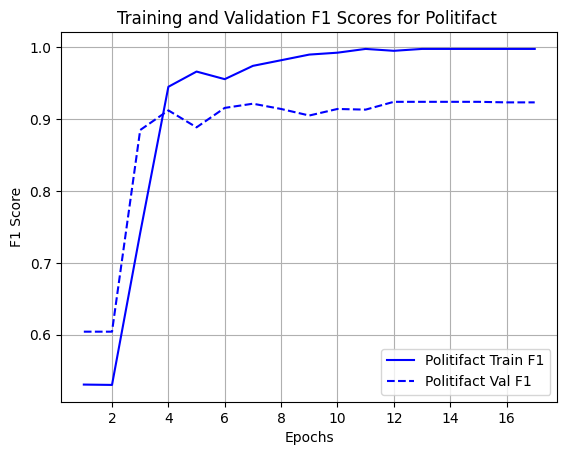

In [33]:
import matplotlib.pyplot as plt

# Extract F1 scores over epochs for Politifact
politifact_train_f1 = politifact_results['history']['train_f1']
politifact_val_f1 = politifact_results['history']['val_f1']


epochs_politifact = range(1, len(politifact_train_f1) + 1)



# Politifact curves
plt.plot(epochs_politifact, politifact_train_f1, label='Politifact Train F1', color='blue', linestyle='-')
plt.plot(epochs_politifact, politifact_val_f1, label='Politifact Val F1', color='blue', linestyle='--')


plt.xlabel('Epochs')
plt.ylabel('F1 Score')
plt.title('Training and Validation F1 Scores for Politifact ')
plt.legend()
plt.grid(True)
plt.show()


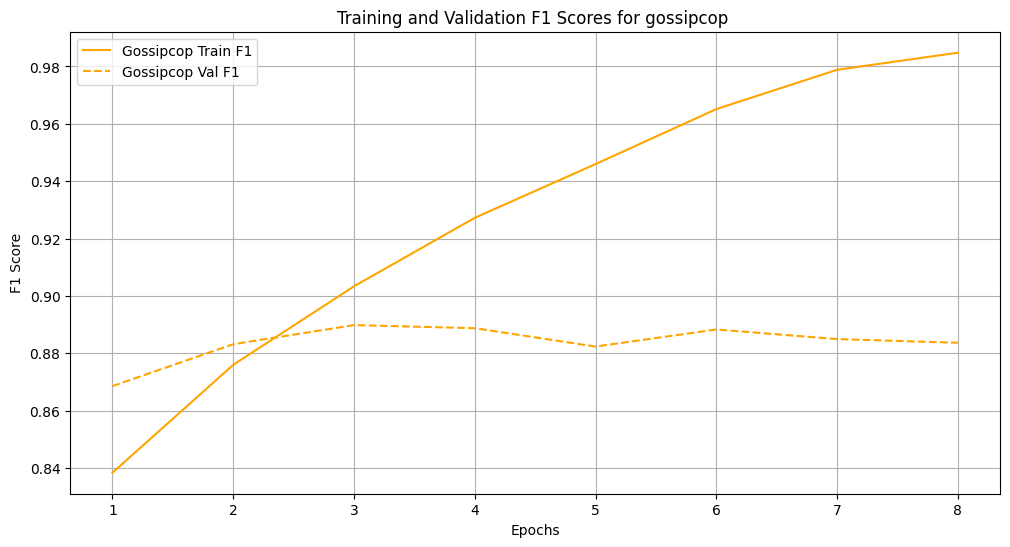

In [34]:
# Extract F1 scores over epochs for Gossipcop
gossipcop_train_f1 = gossipcop_results['history']['train_f1']
gossipcop_val_f1 = gossipcop_results['history']['val_f1']

epochs_gossipcop = range(1, len(gossipcop_train_f1) + 1)
plt.figure(figsize=(12, 6))

# Gossipcop curves
plt.plot(epochs_gossipcop, gossipcop_train_f1, label='Gossipcop Train F1', color='orange', linestyle='-')
plt.plot(epochs_gossipcop, gossipcop_val_f1, label='Gossipcop Val F1', color='orange', linestyle='--')

plt.xlabel('Epochs')
plt.ylabel('F1 Score')
plt.title('Training and Validation F1 Scores for gossipcop ')
plt.legend()
plt.grid(True)
plt.show()


EVALUATING: POLITIFACT
🏗️  Model initialized:
   Text encoder: /kaggle/working/deberta_v3_local
   Image encoder: EfficientNet-B3
   Text features: 768
   Image features: 1536
   Fusion type: attention
   Classifier input dim: 512
📂 Checkpoint loaded from /kaggle/working/best_model_politifact_best.pt


Evaluating Politifact Final Test:   0%|          | 0/13 [00:00<?, ?it/s]


📊 Politifact Test Set Metrics:
   Accuracy:  0.9231
   Precision: 0.9254
   Recall:    0.9231
   F1-Score:  0.9238
   ROC-AUC:   0.9347


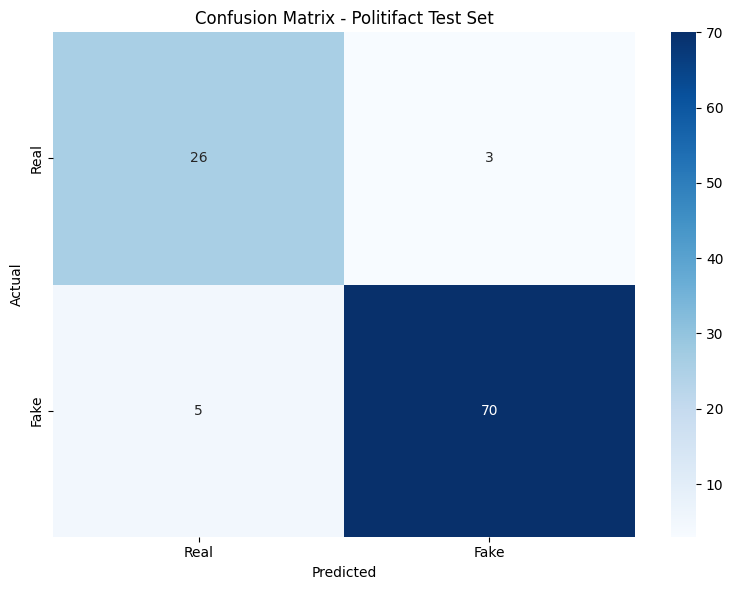


📋 Politifact Classification Report:
              precision    recall  f1-score   support

        Real       0.84      0.90      0.87        29
        Fake       0.96      0.93      0.95        75

    accuracy                           0.92       104
   macro avg       0.90      0.91      0.91       104
weighted avg       0.93      0.92      0.92       104


EVALUATING: GOSSIPCOP
🏗️  Model initialized:
   Text encoder: /kaggle/working/deberta_v3_local
   Image encoder: EfficientNet-B3
   Text features: 768
   Image features: 1536
   Fusion type: attention
   Classifier input dim: 512
📂 Checkpoint loaded from /kaggle/working/best_model_gossipcop_best.pt


Evaluating Gossipcop Final Test:   0%|          | 0/354 [00:00<?, ?it/s]


📊 Gossipcop Test Set Metrics:
   Accuracy:  0.8908
   Precision: 0.8890
   Recall:    0.8908
   F1-Score:  0.8898
   ROC-AUC:   0.9064


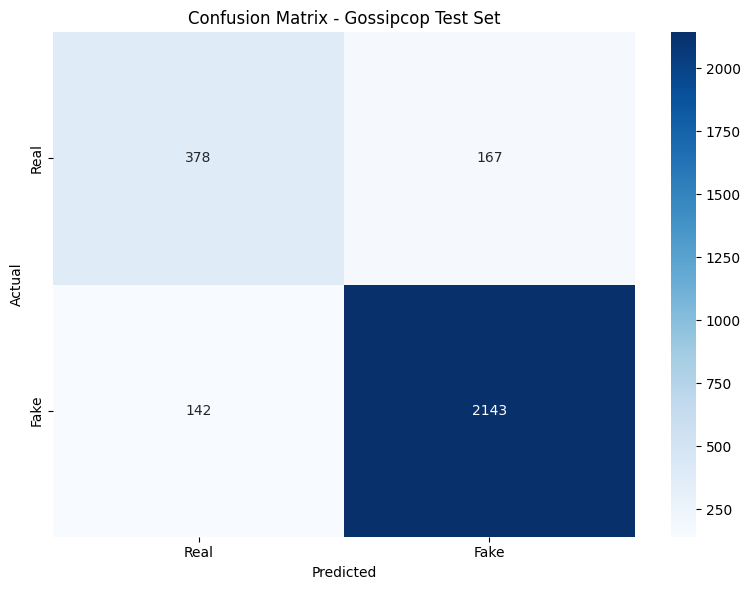


📋 Gossipcop Classification Report:
              precision    recall  f1-score   support

        Real       0.73      0.69      0.71       545
        Fake       0.93      0.94      0.93      2285

    accuracy                           0.89      2830
   macro avg       0.83      0.82      0.82      2830
weighted avg       0.89      0.89      0.89      2830



In [35]:
# Comprehensive Evaluation Function
def comprehensive_evaluation(dataloaders, config):
    """Evaluate saved models on all test sets."""
    results = {}

    for domain_name in dataloaders.keys():
        print(f"\n{'='*60}")
        print(f"EVALUATING: {domain_name.upper()}")
        print(f"{'='*60}")

        # Load best model for this domain
        model_path = config.MODEL_SAVE_PATH.replace('.pt', f'_{domain_name.lower()}_best.pt')

        if os.path.exists(model_path):
            # Create fresh model with LOCAL DeBERTa
            model = MultimodalFakeNewsDetector(
                text_model_name="/kaggle/working/deberta_v3_local",   # ✅ Local load
                num_classes=2,
                fusion_dim=512
            ).to(device)

            # Load checkpoint
            epoch, metrics, _ = load_checkpoint(model_path, model, tokenizer)

            # Evaluate on test set
            test_loader = dataloaders[domain_name]['test']
            test_loss, test_metrics, test_labels, test_preds = evaluate_model(
                model, test_loader, device, f"{domain_name} Final Test"
            )

            # Print detailed results
            print_metrics(test_metrics, f"{domain_name} Test Set")

            # Plot confusion matrix
            plot_confusion_matrix(test_labels, test_preds, f"{domain_name} Test Set")

            # Classification report
            print(f"\n📋 {domain_name} Classification Report:")
            print(classification_report(test_labels, test_preds, target_names=['Real', 'Fake']))

            results[domain_name] = {
                'test_loss': test_loss,
                'test_metrics': test_metrics,
                'test_labels': test_labels,
                'test_preds': test_preds
            }
        else:
            print(f"❌ Model file not found: {model_path}")

    return results

# Run comprehensive evaluation
final_results = comprehensive_evaluation(dataloaders, config)
